In [1]:
cd /Data1/hmd2/notebooks_th/Fix_models/MHA_LSTM/

/Data1/hmd2/notebooks_th/Fix_models/MHA_LSTM


In [2]:
import torch
import random

def collate_fn(x):
    # max_length = cal_max_frame_len(config.sampling_rate, config.sequence_length)
    MAX_LENGTH= 298
    FREQ_BINS = 40
    
    max_length= MAX_LENGTH
    
    all_features = torch.zeros(len(x), FREQ_BINS, max_length)  # [bs, freq, frame]
    all_seq_labels = torch.ones(len(x), 3, max_length) * (-1) # S1, S2, Murmur, 
    all_murmur_labels = []
    all_outcome_labels = []
    pad_masks = []    
    all_filenames = []
    
    for idx, (features, seq_label, murmur_label, outcome_label, wav_len, filename) in enumerate(x):
        
        pad_mask = torch.ones(max_length)
        
        # 같거나 짧음
        if features.shape[-1] <= max_length:
            diff = max_length - features.shape[-1]
            start = random.randint(0, diff)
            end = start + features.shape[-1]
            all_features[idx, :, start : end] = features
            all_seq_labels[idx, : , start : end] = seq_label
            
            pad_mask[start:end] = 0.0 # 데이터 있는 부분이 0.0
            pad_masks.append(pad_mask)
            # actual_seq_lengths.append(len(seq_label))
            all_filenames.append(filename)
        # 더 길면
        else:
            diff = features.shape[-1] - max_length
            start = random.randint(0, diff)
            end =  start + max_length
            all_features[idx, :, :] = features[:, start : end]
            all_seq_labels[idx, :, :] = seq_label[:, start : end]
            
            pad_mask[:] = 0.0 # 모든 시퀀스에 데이터 있으므로 모두 0.0
            pad_masks.append(pad_mask)
            # actual_seq_lengths.append(max_length)

        all_murmur_labels.append(murmur_label)
        all_outcome_labels.append(outcome_label)
        all_filenames.append(filename)
        
    all_features = all_features.float()
    all_seq_labels = all_seq_labels.float()
    all_murmur_labels = torch.stack(all_murmur_labels).float()
    pad_masks = torch.stack(pad_masks).float()
    
    # actual_seq_lengths = torch.as_tensor(actual_seq_lengths)
    # return {"features": all_features, "seq_labels": all_seq_labels, "pad_masks": pad_masks, 
    #         "mm_labels": all_murmur_labels, "oc_labels": all_outcome_labels, "filenames": all_filenames}

    return (all_features, all_seq_labels, pad_masks, all_murmur_labels, all_outcome_labels, all_filenames)


In [3]:
import config
from torch.utils.data import DataLoader, RandomSampler
from dataset import train_dataset, unlabeled_dataset, val_dataset


sampler_unlabeled = RandomSampler(unlabeled_dataset, replacement=True)

train_dataloader = DataLoader(train_dataset, batch_size= config.strong_bs, shuffle=True, collate_fn= collate_fn, num_workers=config.num_workers)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size= config.unlabel_bs, sampler= sampler_unlabeled, collate_fn= collate_fn, num_workers=config.num_workers)
val_dataloader = DataLoader(val_dataset, batch_size= config.val_bs, shuffle=False,  collate_fn= collate_fn, num_workers=config.num_workers) 

# for batch in cycle(unlabeled_dataloader):
#     # 배치 처리 로직
#     # 특정 조건을 확인
#     if condition_met:
#         break


Training with 751 patients!



/opt/conda/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [4]:
1e-3

0.001

In [5]:
len(unlabeled_dataset) 

626

In [6]:
from itertools import cycle

before_unlabel = None 

for i, (batch_strong, batch_unlabel) in enumerate(zip(train_dataloader, cycle(unlabeled_dataloader))):
    
    print(len(batch_unlabel))
    
    print(f"\n{i}\n")

6

0

6

1

6

2

6

3

6

4

6

5

6

6

6

7

6

8

6

9

6

10

6

11

6

12

6

13

6

14

6

15

6

16

6

17

6

18

6

19

6

20

6

21

6

22



In [7]:
len(train_dataset)

1795

In [8]:
10 / 250

0.04

In [9]:
len(train_dataloader)

23

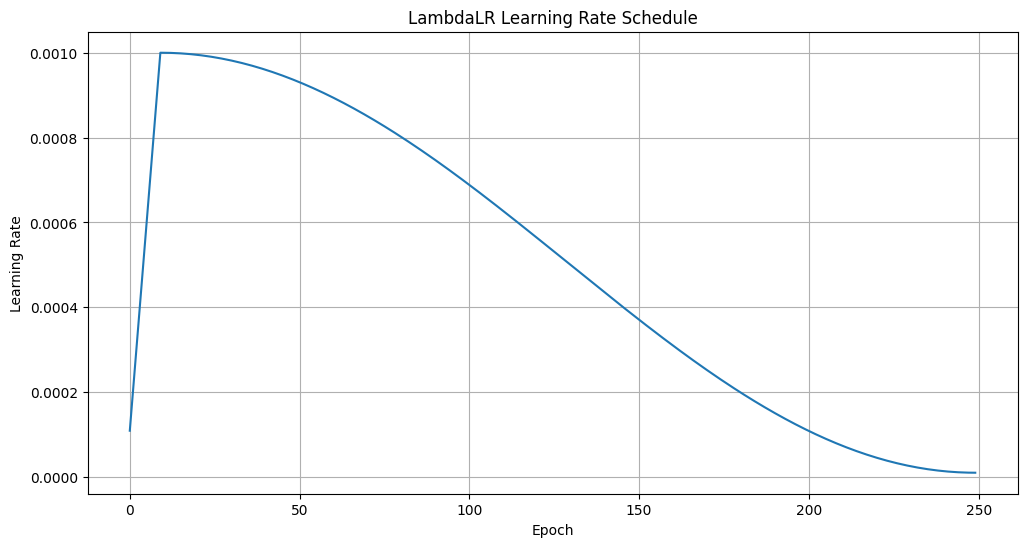

In [10]:
import config
import math
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, OneCycleLR
import matplotlib.pyplot as plt

# 모델 정의 (예시)
model = torch.nn.Linear(10, 2)

# # 옵티마이저 정의 (초기 lr은 base_lr으로 설정)
# base_lr = 4e-5
# max_lr = 0.001
optimizer = optim.AdamW(model.parameters(), lr= config.learning_rate, 
                        weight_decay=1e-2, betas=(0.9, 0.999), eps=1e-8)

# # 학습 설정
# total_epochs = 250
# steps_per_epoch = 23
# total_steps = total_epochs * steps_per_epoch
# max_epoch = 10
# max_step = max_epoch * steps_per_epoch  # 10 에포크 * 23 스텝 = 230 스텝
# total_cosine_steps = total_steps - max_step  # 5750 - 230 = 5520 스텝


# # Lambda 함수 정의
# def lambda_step(step):
#     # print(step)
#     if step < max_step:
#         # 초기 학습률에서 max_lr까지 선형 증가
#         return 1 + (max_lr / base_lr - 1) * (step / max_step)
#     else:
#         # max_lr에서 base_lr까지 코사인 함수로 감소
#         cosine_steps = step - max_step
#         cosine_decay = 0.5 * (1 + math.cos(math.pi * cosine_steps / total_cosine_steps))
#         return 1 + (max_lr / base_lr - 1) * cosine_decay


def lambda_step(step):
    max_lr = config.max_lr
    base_lr = config.learning_rate #4e-5
    
    steps_per_epoch = config.steps_per_epoch
    total_steps = 250 * steps_per_epoch
    max_step = config.pct_start * steps_per_epoch
    total_cosine_steps = total_steps - max_step
    
    if step < max_step:
        # 초기 학습률에서 max_lr까지 선형 증가
        return 1 + (max_lr / base_lr - 1) * (step / max_step)
    else:
        # max_lr에서 base_lr까지 코사인 함수로 감소
        cosine_steps = step - max_step
        cosine_decay = 0.5 * (1 + math.cos(math.pi * cosine_steps / total_cosine_steps))
        return 1 + (max_lr / base_lr - 1) * cosine_decay


# LambdaLR 스케줄러 정의
scheduler = LambdaLR(optimizer, lr_lambda=lambda_step)

# 학습률 기록을 위한 리스트
lrs = []

# 학습 루프 (예시)
for epoch in range(250):
    for batch in range(23):
        # 학습 단계 (예시)
        optimizer.zero_grad()
        inputs = torch.randn(32, 10)
        targets = torch.randint(0, 2, (32,))
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # 학습률 기록
    lrs.append(optimizer.param_groups[0]['lr'])

# 학습률 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('LambdaLR Learning Rate Schedule')
plt.grid(True)
plt.show()


In [11]:
lrs[-1]

1e-05

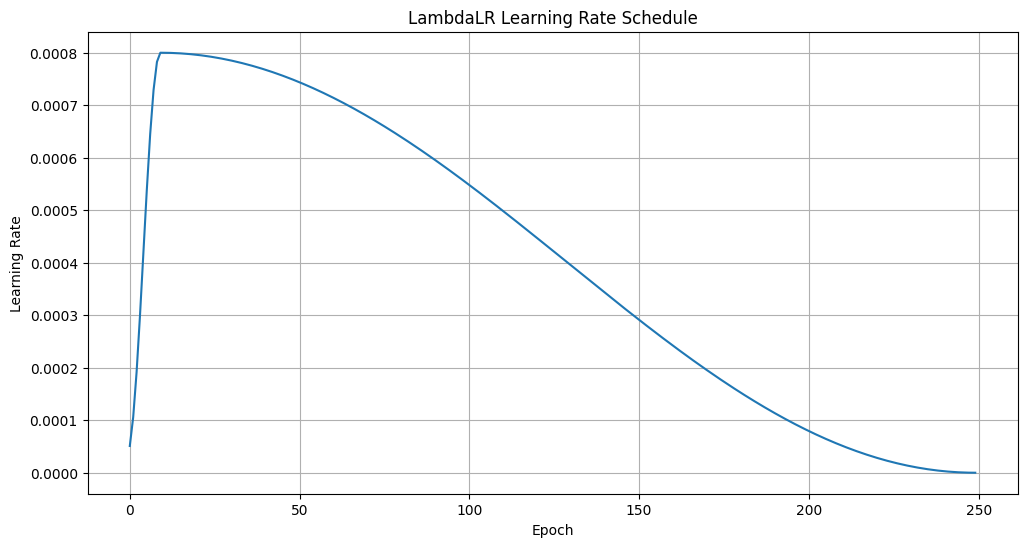

In [17]:
model = torch.nn.Linear(10, 2)

# # 옵티마이저 정의 (초기 lr은 base_lr으로 설정)
# base_lr = 4e-5
# max_lr = 0.001
optimizer = optim.AdamW(model.parameters(), lr= config.learning_rate, 
                        weight_decay=1e-2, betas=(0.9, 0.999), eps=1e-8)

scheduler = OneCycleLR(optimizer, max_lr= 0.0008, 
                            total_steps= config.max_epoch * 23, 
                            pct_start = 10 / config.max_epoch, 
                            div_factor = 25, 
                            final_div_factor=1000,
                            anneal_strategy= "cos")

# 학습률 기록을 위한 리스트
lrs = []

# 학습 루프 (예시)
for epoch in range(250):
    for batch in range(23):
        # 학습 단계 (예시)
        optimizer.zero_grad()
        inputs = torch.randn(32, 10)
        targets = torch.randint(0, 2, (32,))
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # 학습률 기록
    lrs.append(optimizer.param_groups[0]['lr'])

# 학습률 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('LambdaLR Learning Rate Schedule')
plt.grid(True)
plt.show()

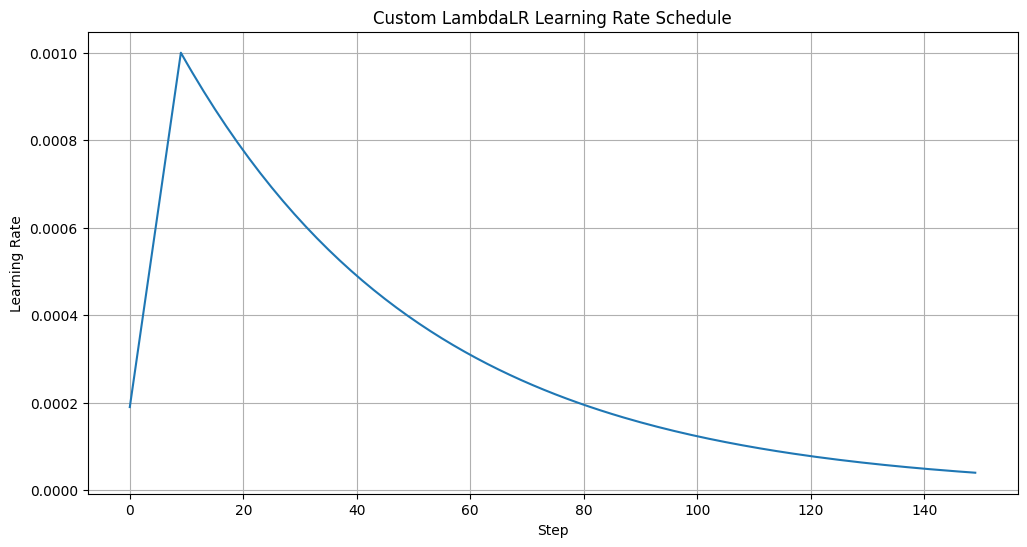

In [5]:
import math
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

def create_custom_lambda_scheduler(optimizer, base_lr=1e-4, max_lr=0.001, final_lr=1e-6,
                                   total_epochs=250, steps_per_epoch=23,
                                   max_epoch=10, decay_rate=None):
    """
    커스텀 LambdaLR 스케줄러를 생성합니다.
    
    Parameters:
    - optimizer: PyTorch 옵티마이저
    - base_lr: 초기 학습률
    - max_lr: 최대 학습률
    - final_lr: 최종 학습률 (총 학습 후 도달)
    - total_epochs: 전체 학습 에포크 수
    - steps_per_epoch: 에포크당 스텝 수
    - max_epoch: 최대 학습률에 도달할 에포크 수
    - decay_rate: 지수적 감소율 (None이면 자동 계산)
    
    Returns:
    - LambdaLR 스케줄러
    """
    total_steps = total_epochs * steps_per_epoch
    max_step = max_epoch * steps_per_epoch

    if decay_rate is None:
        # 자동으로 decay_rate 계산
        # final_lr = max_lr * exp(-decay_rate * (total_steps - max_step))
        decay_rate = math.log(max_lr / final_lr) / (total_steps - max_step)
    
    def lr_lambda(step):
        if step < max_step:
            # 선형 증가: base_lr -> max_lr
            return 1 + (max_lr / base_lr - 1) * (step / max_step)
        else:
            # 지수적 감소: max_lr -> final_lr
            return (max_lr / base_lr) * math.exp(-decay_rate * (step - max_step))
    
    return LambdaLR(optimizer, lr_lambda=lr_lambda)

# 모델 및 옵티마이저 정의 (예시)
model = torch.nn.Linear(10, 2)
optimizer = optim.SGD(model.parameters(), lr=1e-4)  # base_lr 설정

# 커스텀 LambdaLR 스케줄러 생성
scheduler = create_custom_lambda_scheduler(
    optimizer=optimizer,
    base_lr=1e-4,
    max_lr=0.001,
    final_lr=1e-6,
    total_epochs=250,
    steps_per_epoch= 23,
    max_epoch=10,
    decay_rate= 1e-3 # 기본값으로 자동 계산
)

# 학습률 기록을 위한 리스트
lrs = []

# 학습 루프 (예시)
total_epochs = 250
steps_per_epoch = 23

for epoch in range(total_epochs):
    for batch in range(steps_per_epoch):
        # 예시 학습 단계
        optimizer.zero_grad()
        inputs = torch.randn(32, 10)
        targets = torch.randint(0, 2, (32,))
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # 현재 학습률 기록
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)

# 학습률 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(lrs[:-100])
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Custom LambdaLR Learning Rate Schedule')
plt.grid(True)
plt.show()


In [3]:
lrs[-1]

1.0000000000000002e-06

In [2]:
import torch
import torch.nn.functional as F

a = torch.randn(1, 2)
F.softmax(a, dim= 0)


tensor([[1., 1.]])

In [ ]:

def create_custom_lambda_scheduler(optimizer, base_lr=1e-4, max_lr=0.001, final_lr=1e-6,
                                   total_epochs=250, steps_per_epoch=23,
                                   max_epoch=10, decay_rate=None):
    """
    커스텀 LambdaLR 스케줄러를 생성합니다.
    
    Parameters:
    - optimizer: PyTorch 옵티마이저
    - base_lr: 초기 학습률
    - max_lr: 최대 학습률
    - final_lr: 최종 학습률 (총 학습 후 도달)
    - total_epochs: 전체 학습 에포크 수
    - steps_per_epoch: 에포크당 스텝 수
    - max_epoch: 최대 학습률에 도달할 에포크 수
    - decay_rate: 지수적 감소율 (None이면 자동 계산)
    
    Returns:
    - LambdaLR 스케줄러
    """
    total_steps = total_epochs * steps_per_epoch
    max_step = max_epoch * steps_per_epoch

    if decay_rate is None:
        # 자동으로 decay_rate 계산
        # final_lr = max_lr * exp(-decay_rate * (total_steps - max_step))
        decay_rate = math.log(max_lr / final_lr) / (total_steps - max_step)
    
    def lr_lambda(step):
        if step < max_step:
            # 선형 증가: base_lr -> max_lr
            return 1 + (max_lr / base_lr - 1) * (step / max_step)
        else:
            # 지수적 감소: max_lr -> final_lr
            return (max_lr / base_lr) * math.exp(-decay_rate * (step - max_step))
    
    return LambdaLR(optimizer, lr_lambda=lr_lambda)

scheduler = create_custom_lambda_scheduler(
    optimizer= optim,
    base_lr= config.learning_rate,
    max_lr= 0.001,
    final_lr= 1e-6,
    total_epochs= 250,
    steps_per_epoch= 23,
    max_epoch= 10,
    decay_rate= 1e-4 * 3 # 미할당시 기본값으로 계산
)